In [19]:
import netCDF4 as nc

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import scipy
from inspect import signature

In [3]:
path = '/Users/zcaspar/codes/Diagnostics/'

In [4]:
corrL = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

In [129]:
corrE = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

## Model fit : 

In [26]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,xt):
    return xt*np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,xb,Om):
    return xb*np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,xt,Tb,xb,Omega,Xbar,Xtilde):
    return Xbar*Cbar(t,Tb,xb,Omega)+Xtilde*Ctilde(t,Tt,xt)

#### Notes : 
For now, the node is not fitted (no explaination and fit more difficult for the tot£al signal)

In [42]:
def param_fit(x,myfunc,var,X = 'normalized'):
    """Find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Correaltionfunction to fit
        myfunc: func
                Function used for the fit
        var : str
              variable to fit
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    
    if X=='normalized':
        _x = x[var]/x[var].sel(lags=0) 
    else :
        _x = x[var]
 #   pa = np.full((1,len(sig.parameters)-1),np.nan)
    pa,co = scipy.optimize.curve_fit(myfunc,_x.lags,_x)
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = xr.Dataset({'params':(['y','param'],pa)},
                     coords={'y':_.ybins.values,'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

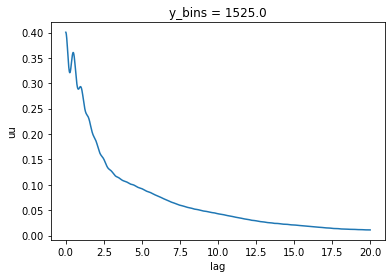

In [43]:
corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest').plot()

In [107]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [98]:
out = fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest'),C,(0,np.inf),False)



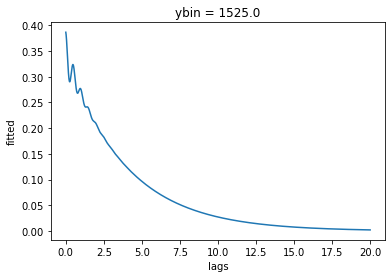

In [99]:
out.fitted.plot()

In [109]:
out_comb = xr.concat([fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          C,(0,np.inf),False) for Y in corrL['avg1d']['uu'].y_bins],dim='ybin')

In [130]:
out_combE = xr.concat([fit(corrE['avg1d']['uu'].lag,corrE['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          C,(0,np.inf),False) for Y in corrE['avg1d']['uu'].y_bins],dim='ybin')

In [70]:
np.array([corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest').y_bins.values]).shape

(1,)

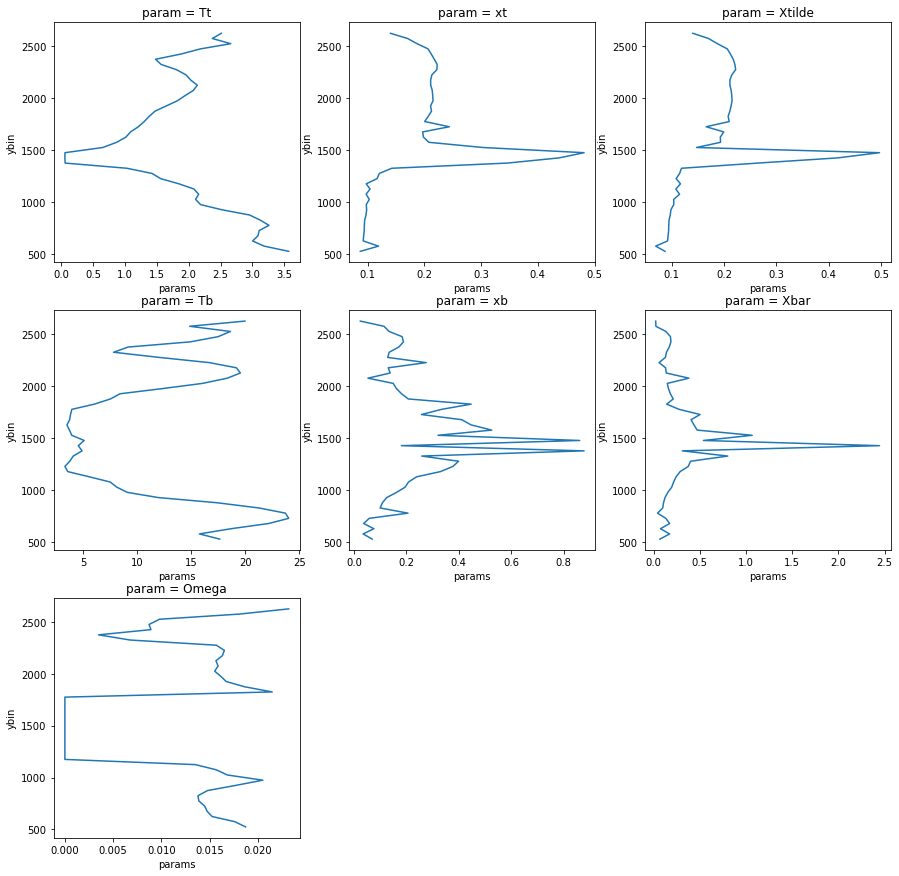

In [123]:
fig,axes = plt.subplots(3,3,figsize=(15,15))
for pa,ax in zip(['Tt','xt','Xtilde'],axes[0,:]):
    out_comb.params.sel(param=pa).plot(y='ybin',ax=ax)
for pa,ax in zip(['Tb','xb','Xbar'],axes[1,:]):
    out_comb.params.sel(param=pa).plot(y='ybin',ax=ax)
out_comb.params.sel(param='Omega').plot(y='ybin',ax=axes[2,0])
fig.delaxes(axes[2,1]);fig.delaxes(axes[2,2])